In [1]:
import pickle as pkl    
import os
from pcdet.ops.iou3d_nms import iou3d_nms_utils
import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

import torch
os.chdir('/home/cgriesbacher/thesis/3DTrans/')

### Init functions

In [2]:
def calc_ious(pseudo_labels, gt_labels):
    #pseudo_labels = pseudo_labels.copy()
    #gt_labels = gt_labels.copy()
    #add iou score to the dataframe, default is 0 , use .loc[row_indexer,col_indexer] = value instead
    pseudo_labels['iou'] = 0
    gt_labels['iou'] = 0
    pseudo_labels['true_label'] = "Background"

    #det detection frame ids
    ps_frame_ids = pseudo_labels['frame_id'].unique()

    num_no_labels = 0
    num_label = 0
    # Loop over all frames
    pbar = tqdm.tqdm(ps_frame_ids)
    for ps_frame_id in pbar:

        gt_labels_frame = gt_labels[gt_labels['frame_id'] == ps_frame_id]
        pseudo_labels_frame = pseudo_labels[pseudo_labels['frame_id'] == ps_frame_id]

        if len(gt_labels_frame) == 0 or len(pseudo_labels_frame) == 0:
            #print(f"Frame {ps_frame_id} has no gts or no detections")
            num_no_labels += 1
            no_label_perc = round((num_no_labels/(num_label+num_no_labels)* 100),2) 
            pbar.set_description(f"No label percentage: {no_label_perc}%")
            continue
        else:
            num_label += 1

        # Convert the boxes to numpy
        gt_boxes_frame = np.stack(gt_labels_frame["gt_boxes_lidar"].values)
        ps_boxes_frame = np.stack(pseudo_labels_frame["boxes_lidar"].values)

        #iou_matrix = iou3d_nms_utils.boxes_iou3d_gpu(torch.tensor(gt_boxes_frame, dtype=torch.float, device='cuda'), torch.tensor(ps_boxes_frame, dtype=torch.float, device='cuda')).cpu().numpy()
        iou_matrix = iou3d_nms_utils.boxes_iou_bev(torch.tensor(gt_boxes_frame, dtype=torch.float, device='cuda'), torch.tensor(ps_boxes_frame, dtype=torch.float, device='cuda')).cpu().numpy()
        #iou_matrix = iou3d_nms_utils.boxes_bev_iou_cpu(gt_boxes_frame, ps_boxes_frame)
        
        # Get the max iou for each det box
        max_ious_ps = np.max(iou_matrix, axis=0)
        max_ious_ps_idx = np.argmax(iou_matrix, axis=0)

        # get class for each detection
        cls_dets = gt_labels_frame['names'].values[max_ious_ps_idx]
        
        # Update the iou score for each detection in the original DataFrame
        pseudo_labels.loc[pseudo_labels_frame.index, 'iou'] = max_ious_ps

        #TODO: only update label if it is higher than 0!!
        pseudo_labels.loc[pseudo_labels_frame.index, 'true_label'] = cls_dets
        # print(f"Percentage of detection ious greater than 0: {round(len(max_ious_ps[max_ious_ps > 0])/len(max_ious_ps),2)}")

        # Get max_iou for each gt box
        max_ious_gts = np.max(iou_matrix, axis=1)

        # Update the iou score for each gt in the original DataFrame
        gt_labels.loc[gt_labels_frame.index, 'iou'] = max_ious_gts
        #percentage of ious that are greater than 0
        # print(f"Percentage of gt ious greater than 0: {round(len(max_ious_gts[max_ious_gts > 0])/len(max_ious_gts),2)}")

        # XXX: only update if score is higher than current score


    iou_thresholds = [0.1, 0.3, 0.5, 0.7]

    #for each detection, add detected_0.3, detected_0.5, detected_0.7
    for iou_threshold in iou_thresholds:
        pseudo_labels[f'detected_{iou_threshold}'] = pseudo_labels['iou'] >= iou_threshold
        gt_labels[f'detected_{iou_threshold}'] = gt_labels['iou'] >= iou_threshold

    return pseudo_labels, gt_labels

def load_pseudo_labels(path, df, train_dataset=None, eval_dataset=None, epoch=None):
    label_map = {
        1: "Vehicle",
        2: "Pedestrian",
        3: "Cyclist",
        4: "Truck",
        -1: "Unsure",
        #'Placeholder': 'DontCare',
    }
    with open(path, 'rb') as f:
        pseudo_labels = pkl.load(f)

    #add key as dict entry "frame_id"
    for frame_id in pseudo_labels:
        pseudo_labels[frame_id]['frame_id'] = frame_id
    
    #convert to dicts to list
    pseudo_labels_frames = list(pseudo_labels.values())
    
    scores = []
    names = []
    boxes_lidar = []
    frame_ids = []

    for frame_i in range(len(pseudo_labels_frames)):
        for det_i in range(pseudo_labels_frames[frame_i]['gt_boxes'].shape[0]):
            scores.append(pseudo_labels_frames[frame_i]['gt_boxes'][det_i][-1])
            names.append(label_map[int(pseudo_labels_frames[frame_i]['gt_boxes'][det_i][-2])])
            boxes_lidar.append(pseudo_labels_frames[frame_i]['gt_boxes'][det_i][:-2])
            frame_ids.append(frame_i)

    #lists to dataset
    pseudo_labels = {'score': scores, 'name': names, 'boxes_lidar': boxes_lidar, 'frame_id': frame_ids}

    #make a dataframe
    pseudo_labels = pd.DataFrame(pseudo_labels)

    #get datasset name from path
    if eval_dataset == None:
        eval_dataset = path.split('/')[-2]
    if train_dataset == None:
        train_dataset = path.split('/')[-8].split('_')[0]

    # add a column with the dataset name
    pseudo_labels['eval_dataset'] = eval_dataset
    pseudo_labels['train_dataset'] = train_dataset

    if epoch is not None:
        pseudo_labels['epoch'] = epoch

    pseudo_labels = pseudo_labels.dropna()

    df_new = pd.concat([df, pseudo_labels], axis=0)
    df_new = df_new.reset_index(drop=True)

    print("loaded {} pseudo labels on dataset {} with model trained on {}".format(len(pseudo_labels), eval_dataset, train_dataset))

    return df_new.copy()

def load_detections(path, df, train_dataset=None, eval_dataset=None):
    with open(path, 'rb') as f:
        dets = pkl.load(f)

    #make a dataframe
    df_dets_dataset = pd.DataFrame(dets)
    
    #get datasset name from path
    if eval_dataset == None:
        eval_dataset = path.split('/')[-2]
    if train_dataset == None:
        train_dataset = path.split('/')[-8].split('_')[0]


    #add a column with the dataset name
    df_dets_dataset['eval_dataset'] = eval_dataset
    df_dets_dataset['train_dataset'] = train_dataset

    cols_to_explode = ['name', 'score', 'boxes_lidar', 'pred_labels', 'train_dataset', 'eval_dataset', 'frame_id']
    exploded_list = [df_dets_dataset[col].explode() for col in cols_to_explode]
    exploded_df = pd.concat(exploded_list, axis=1)

    # Adding non-exploded columns
    for col in df_dets_dataset.columns:
        if col not in cols_to_explode:
            exploded_df[col] = df[col].values[0]

    # Reset index if needed
    df_det_expl = exploded_df.reset_index(drop=True)

    df_det_expl = df_det_expl.dropna()

    df_new = pd.concat([df, df_det_expl], axis=0)
    df_new = df_new.reset_index(drop=True)

    print("loaded {} detections on dataset {} with model trained on {}".format(len(df_det_expl), eval_dataset, train_dataset))

    return df_new.copy()


def load_gt_labels(split):

    assert split in ['train', 'val']
    dataset_names = ["avltruck", "avlrooftop", "zod"]

    #annotation paths
    annotation_path_avltruck = "/home/cgriesbacher/thesis/3DTrans/data/avltruck/avl_infos_"+split+".pkl"
    annotation_path_avlrooftop = "/home/cgriesbacher/thesis/3DTrans/data/avlrooftop/avl_infos_"+split+".pkl"
    annotation_path_zod = "/home/cgriesbacher/thesis/3DTrans/data/zod/zod_infos_"+split+"_full.pkl"

    #load the annotations and make a dataframe
    with open(annotation_path_avltruck, 'rb') as f:
        annotations_avltruck = pkl.load(f)
    with open(annotation_path_avlrooftop, 'rb') as f:
        annotations_avlrooftop = pkl.load(f)
    with open(annotation_path_zod, 'rb') as f:
        annotations_zod = pkl.load(f)

    avltruck_content = []
    for i in range(len(annotations_avltruck)):
        content = {}
        content["names"] = annotations_avltruck[i]["annos"]['name']
        content["gt_boxes_lidar"] = annotations_avltruck[i]["annos"]['gt_boxes_lidar']
        content['dataset'] = dataset_names[0]
        content['frame_id'] = annotations_avltruck[i]["point_cloud"]['lidar_idx']
        avltruck_content.append(content)

    avlrooftop_content = []
    for i in range(len(annotations_avlrooftop)):
        content = {}
        content["names"] = annotations_avlrooftop[i]["annos"]['name']
        content["gt_boxes_lidar"] = annotations_avlrooftop[i]["annos"]['gt_boxes_lidar']
        content['dataset'] = dataset_names[1]
        content['frame_id'] = annotations_avlrooftop[i]["point_cloud"]['lidar_idx']
        avlrooftop_content.append(content)

    zod_content = []
    for i in range(len(annotations_zod)):
        content = {}
        content["names"] = annotations_zod[i]["annos"]['name']
        content["gt_boxes_lidar"] = annotations_zod[i]["annos"]['gt_boxes_lidar']
        content['dataset'] = dataset_names[2]
        content['frame_id'] = annotations_zod[i]["point_cloud"]['lidar_idx']
        zod_content.append(content)

    #make a dataframe
    df_avltruck_annos = pd.DataFrame(avltruck_content)
    df_avlrooftop_annos = pd.DataFrame(avlrooftop_content)
    df_zod_annos = pd.DataFrame(zod_content)

    #make a dataframe with all results
    df_annos_full = pd.concat([df_avltruck_annos, df_avlrooftop_annos, df_zod_annos], axis=0) 
    df_annos_full = df_annos_full.reset_index(drop=True)

    #explode the lists
    cols_to_explode = ['names', 'gt_boxes_lidar', 'dataset', 'frame_id']
    df_annos_lists = [df_annos_full[col].explode() for col in cols_to_explode]
    df_annos_full = pd.concat(df_annos_lists, axis=1)

    prev_len = len(df_annos_full)
    df_annos_full.dropna(inplace=True)
    print(f"Dropped {prev_len - len(df_annos_full)} rows with NaNs")


    namemap_avltruck = {
        "Vehicle_Drivable_Car": "Vehicle",
        "Vehicle_Drivable_Van": "Vehicle",
        "Vehicle_Ridable_Motorcycle": "Cyclist",
        "Vehicle_Ridable_Bicycle": "Cyclist",
        "Human": "Pedestrian",
        "LargeVehicle_Bus": "Truck",
        "LargeVehicle_TruckCab": "Truck",
        "LargeVehicle_Truck": "Truck",
        "Trailer": "Truck",
        "Dont_Care": "DontCare",
        "Other": "DontCare",
        #'Placeholder': 'DontCare',
    }

    namemap_avlrooftop =  {
        "Vehicle_Drivable_Car": "Vehicle",
        "Vehicle_Drivable_Van": "Vehicle",
        "LargeVehicle_Truck": "Truck",
        "LargeVehicle_TruckCab": "Truck",
        "LargeVehicle_Bus": "Truck",
        "LargeVehicle_Bus_Bendy": "Truck",
        "Trailer": "Truck",
        "Vehicle_Ridable_Motorcycle": "Cyclist",
        "Vehicle_Ridable_Bicycle": "Cyclist",
        "Human": "Pedestrian",
        "PPObject": "DontCare",
        "PPObject_Stroller": "DontCare",
        "Dont_care": "DontCare",
        #'Placeholder': 'DontCare',
    }

    namemap_zod = {
        "Vehicle_Car": "Vehicle",
        "Vehicle_Van": "Vehicle",
        "Vehicle_Truck": "Truck",
        "Vehicle_Trailer": "Truck",
        "Vehicle_Bus": "Truck",
        "Vehicle_HeavyEquip": "Truck",
        "Vehicle_TramTrain": "Truck",
        "VulnerableVehicle_Motorcycle": "Cyclist",
        "VulnerableVehicle_Bicycle": "Cyclist",
        "Pedestrian": "Pedestrian",
        #'Placeholder': 'DontCare',
    }

    #apply name maps for all data of each dataset
    df_annos_full['names'] = df_annos_full['names'].apply(lambda x: namemap_avltruck[x] if x in namemap_avltruck.keys() else x)
    df_annos_full['names'] = df_annos_full['names'].apply(lambda x: namemap_avlrooftop[x] if x in namemap_avlrooftop.keys() else x)
    df_annos_full['names'] = df_annos_full['names'].apply(lambda x: namemap_zod[x] if x in namemap_zod.keys() else x)

    #drop all dont cares
    df_annos_full = df_annos_full[df_annos_full['names'] != 'DontCare']

    return df_annos_full

def plot_confusion_matrix(pseudo_labels, gt_labels, iou_threshold, epochs, pseudo_labels_folder_path=None, show_plot=True, do_print=False):
    if do_print:
        #print number of detections
        print(f"Number of detections: {len(pseudo_labels)}")
        #num dets per frame
        print(f"Number of detections per frame: {round(len(pseudo_labels)/len(pseudo_labels['frame_id'].unique()),2)}")

        #num gt
        print(f"Number of gt: {len(gt_labels)}")
        #num gt per frame
        print(f"Number of gt per frame: {round(len(gt_labels)/len(gt_labels['frame_id'].unique()),2)}")

        print()


    #detected as _ true label
    pseudo_labels_vehicles = pseudo_labels[pseudo_labels['name'] == 'Vehicle']
    vehicles_vehicle = len(pseudo_labels_vehicles[(pseudo_labels_vehicles[f'detected_{iou_threshold}'] == True) & (pseudo_labels_vehicles['true_label'] == 'Vehicle')])
    vehicles_other = len(pseudo_labels_vehicles[(pseudo_labels_vehicles[f'detected_{iou_threshold}'] == True) & (pseudo_labels_vehicles['true_label'] == 'Other')])
    vehicles_background = len(pseudo_labels_vehicles[(pseudo_labels_vehicles[f'detected_{iou_threshold}'] == False)])

    pseudo_labels_other = pseudo_labels[pseudo_labels['name'] == 'Other']
    other_vehicle = len(pseudo_labels_other[(pseudo_labels_other[f'detected_{iou_threshold}'] == True) & (pseudo_labels_other['true_label'] == 'Vehicle')])
    other_other = len(pseudo_labels_other[(pseudo_labels_other[f'detected_{iou_threshold}'] == True) & (pseudo_labels_other['true_label'] == 'Other')])
    other_background = len(pseudo_labels_other[(pseudo_labels_other[f'detected_{iou_threshold}'] == False)])

    pseudo_labels_unsure = pseudo_labels[pseudo_labels['name'] == 'Unsure']
    unsure_vehicle = len(pseudo_labels_unsure[(pseudo_labels_unsure[f'detected_{iou_threshold}'] == True) & (pseudo_labels_unsure['true_label'] == 'Vehicle')]) 
    unsure_other = len(pseudo_labels_unsure[(pseudo_labels_unsure[f'detected_{iou_threshold}'] == True) & (pseudo_labels_unsure['true_label'] == 'Other')])
    unsure_background = len(pseudo_labels_unsure[(pseudo_labels_unsure[f'detected_{iou_threshold}'] == False)])

    background_vehicle = len(gt_labels[(gt_labels[f'detected_{iou_threshold}'] == False) & (gt_labels['names'] == 'Vehicle')])
    background_other = len(gt_labels[(gt_labels[f'detected_{iou_threshold}'] == False) & (gt_labels['names'] == 'Other')])

    if do_print:
        print("Detected as vehicle, true label vehicle: ", vehicles_vehicle)
        print("Detected as vehicle, true label other: ", vehicles_other)
        print("Detected as vehicle, true label background: ", vehicles_background)
        print()
        print("Detected as other, true label vehicle: ", other_vehicle)
        print("Detected as other, true label other: ", other_other)
        print("Detected as other, true label background: ", other_background)
        print()
        print("Detected as unsure, true label vehicle: ", unsure_vehicle)
        print("Detected as unsure, true label other: ", unsure_other)
        print("Detected as unsure, true label background: ", unsure_background)

#    confusion_matrix = [[0, vehicles_background, other_background, unsure_background],
#                        [background_vehicle, vehicles_vehicle, other_vehicle, unsure_vehicle],
#                        [background_other, vehicles_other, other_other, unsure_other],
#                        [0, 0, 0, 0]]
    
    confusion_matrix = [[0, vehicles_background, unsure_background],
                        [background_vehicle, vehicles_vehicle, unsure_vehicle],
                        [0, 0, 0]]
    confusion_matrix = np.array(confusion_matrix)

    plt.figure(figsize=(10, 5))
    plt.title('Confusion matrix epoch'+str(epochs)+' iou'+str(iou_threshold))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xticks(np.arange(3)+0.5, ['Background', 'Vehicle', 'Unsure'])
    #plt.xticks(np.arange(4)+0.5, ['Background', 'Vehicle', 'Other', 'Unsure'])
    plt.yticks(np.arange(3)+0.5, ['Background', 'Vehicle', 'Unsure'])
    #plt.yticks(np.arange(4)+0.5, ['Background', 'Vehicle', 'Other', 'Unsure'])
    plt.ylabel('True label')
    plt.xlabel('Pseudo label')

    if pseudo_labels_folder_path is not None:
        #save image to path pseudo_labels_folder_path
        plt.savefig(os.path.join(pseudo_labels_folder_path, f"confusion_matrix_e{epochs}_iou{iou_threshold}.png"), dpi=300)

    if show_plot:
        plt.show()

### Load gt labels

In [3]:
split = "train"
gt_labels_all = load_gt_labels(split)
gt_labels_all["dataset"].value_counts()

Dropped 2796 rows with NaNs


zod           1292409
avltruck       555005
avlrooftop      97246
Name: dataset, dtype: int64

### Load detections from gace folder

In [43]:
#init empty dataframe
detections_all = pd.DataFrame()

#between  1 and 2 percent label increase over all precision values for vehicles, more for cars
#folder_name = "2023-12-13_16-10-55"     #avltrck -> ZOD no scores
#folder_name = "2023-12-18_15-16-02"     #avltrck -> ZOD
#folder_name = "2023-12-18_15-42-25"     #avltrck -> ZOD 0.1 noise
#folder_name = "2023-12-18_15-44-22"     #avltrck -> ZOD 0.2 noise
#folder_name = "2023-12-18_16-03-08"     #avltrck -> ZOD 0.3 noise

#folder_name = "2023-12-19_14-58-46"    #avltrck -> ZOD gt boxes for tp
#folder_name = "2023-12-19_16-03-59"    #avltrck -> ZOD no score gt boxes for tp

#folder_name = "2023-12-20_11-42-57"    #avltrck -> ZOD vehicle only
#folder_name = "2023-12-20_13-18-29"    #avltrck -> ZOD vehicle only with noise 0.1

#folder_name = "2023-12-20_14-03-22"    #avltrck -> ZOD vehicle only with gt boxes

#folder_name = "2023-12-28_09-56-45_AVLTruckDataset_ZODDataset_3"    #avltrck -> ZOD ROS
#folder_name = "2023-12-27_19-43-36_AVLTruckDataset_ZODDataset_40"    #avltrck -> ZOD ROS

#folder_name = "2023-12-21_10-31-24"    #avltrck -> avlrooftop ROS

#folder_name = "2023-12-21_11-02-48"    #avltrck -> avlrooftop ROS no nr_pts

#folder_name = "2023-12-21_11-53-53"    #zod -> avltruck ROS 

#folder_name = "2023-12-21_14-21-52_ZODDataset_.."    #zod -> avlrooftop ROS

#folder_name = "2023-12-21_15-03-23_AVLRooftopDataset_ZODDataset_5"  #ROS 

#folder_name = "2023-12-21_16-18-03_AVLRooftopDataset_AVLTruckDataset_10"  #ROS 

#folder_name = "2023-12-28_11-00-16_AVLTruckDataset_ZODDataset_-1"    #avltrck -> ZOD training set no ros

folder_name = "2024-01-30_17-16-44_AVLTruckDataset_ZODDataset_10"

source_dataset_name = "avltruck"
target_dataset_name = "zod"

results_path_avltruck_gace = "/home/cgriesbacher/thesis/3DTrans/gace/gace_output/"+folder_name+"/det_annos_gace.pkl"
detections_gace = pd.DataFrame()
detections_gace = load_detections(results_path_avltruck_gace, detections_gace, train_dataset=source_dataset_name, eval_dataset=target_dataset_name+"_gace")

results_path_avltruck = "/home/cgriesbacher/thesis/3DTrans/gace/gace_output/"+folder_name+"/det_annos.pkl"
detections_no_gace = pd.DataFrame()
detections_no_gace = load_detections(results_path_avltruck, detections_no_gace, train_dataset=source_dataset_name, eval_dataset=target_dataset_name)


loaded 2645 detections on dataset zod_gace with model trained on avltruck
loaded 2645 detections on dataset zod with model trained on avltruck


### load detections from ps folder

In [15]:
source_dataset_name = "avltruck"
target_dataset_name = "zod"

ps_labal_path = "/home/cgriesbacher/thesis/3DTrans/output_okeanos/avltruck_models/pvrcnnpp_STzod_ped/D16_21epochs_STzod_ft_D6_50epochs_fov_gace_labelupdate_longerepochs/ps_label"
epoch = 7

detections_gace = pd.DataFrame()
results_path_gace = ps_labal_path + "/det_annos_gace_e"+str(epoch)+".pkl"
detections_gace = load_detections(results_path_gace, detections_gace, train_dataset=source_dataset_name, eval_dataset=target_dataset_name+"_gace")

detections_no_gace = pd.DataFrame()
results_path_no_gace = ps_labal_path + "/det_annos_e"+str(epoch)+".pkl"
detections_no_gace = load_detections(results_path_no_gace, detections_no_gace, train_dataset=source_dataset_name, eval_dataset=target_dataset_name)


loaded 19121 detections on dataset zod_gace with model trained on avltruck
loaded 19121 detections on dataset zod with model trained on avltruck


In [44]:
#init empty dataframe
detections_all = pd.DataFrame()

#select detections based on score
lower_bound = 0.0
upper_bound = 1.0
selection_mask = (detections_no_gace['score'] >= lower_bound) & (detections_no_gace['score'] <= upper_bound)
detections_gace = detections_gace[selection_mask]
detections_no_gace = detections_no_gace[selection_mask]

detections_gace["score_change"] = detections_gace["score"] - detections_no_gace["score"]
detections_gace["prev_score"] = detections_no_gace["score"]
detections_all = pd.concat([detections_gace, detections_no_gace], axis=0)

#print number of detections for each class
print("Number of detections for each class")
print(detections_all['name'].value_counts())
print()

#print in percent of all labels
print("Number of detections for each class in percent of all labels")
print(detections_all['name'].value_counts(normalize=True))
print()



Number of detections for each class
Pedestrian    5290
Name: name, dtype: int64

Number of detections for each class in percent of all labels
Pedestrian    1.0
Name: name, dtype: float64



### Analyze score over range of one specific dataset

/tmp/ipykernel_1383709/1449736115.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_det_vehicles['x'] = df_det_vehicles['boxes_lidar'].apply(lambda x: x[0])
/tmp/ipykernel_1383709/1449736115.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_det_vehicles['y'] = df_det_vehicles['boxes_lidar'].apply(lambda x: x[1])
/tmp/ipykernel_1383709/1449736115.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


zod_gace


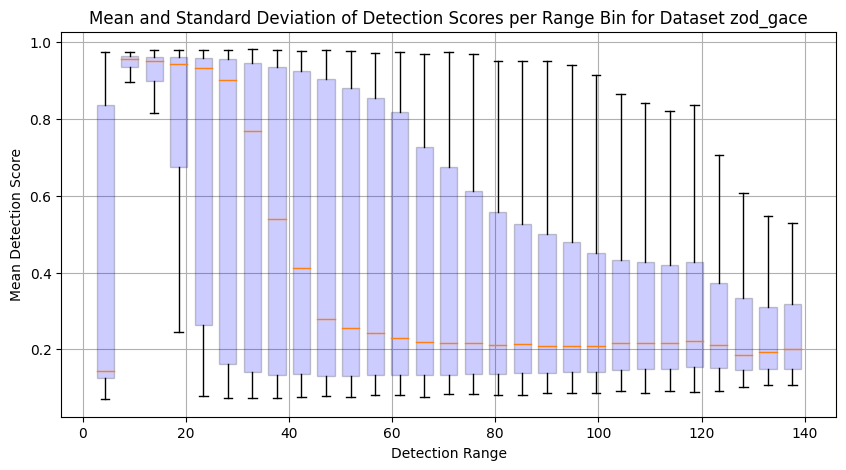

zod


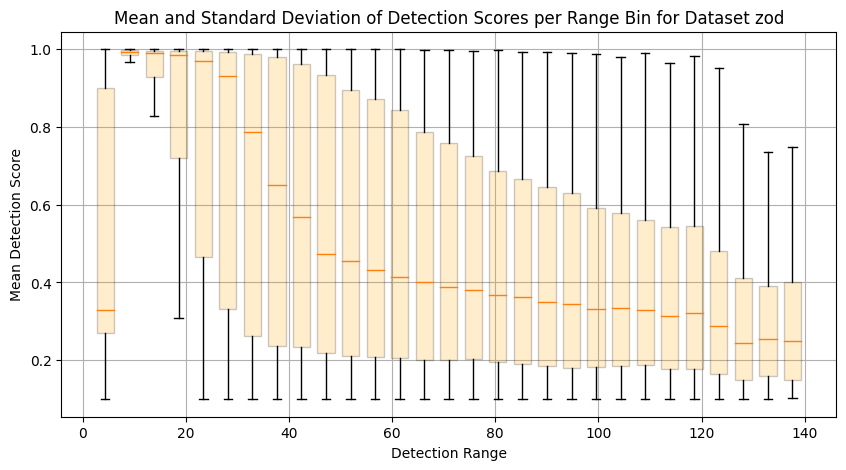

In [6]:
df_det_vehicles = detections_all[detections_all['name'] == 'Vehicle']

#add x and y
df_det_vehicles['x'] = df_det_vehicles['boxes_lidar'].apply(lambda x: x[0])
df_det_vehicles['y'] = df_det_vehicles['boxes_lidar'].apply(lambda x: x[1])

#add range
df_det_vehicles['range'] = np.sqrt(df_det_vehicles['x']**2 + df_det_vehicles['y']**2)

train_datasets = df_det_vehicles['train_dataset'].unique()
eval_datasets = df_det_vehicles['eval_dataset'].unique()


#for dataset in datasets
for j, dataset in enumerate(eval_datasets):
    print(dataset)
    plt.figure(figsize=(10, 5))
    plt.title('Detection Score per Range Bin')

    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    #df = df_det_vehicles[df_det_vehicles['dataset'] == dataset]
    df = df_det_vehicles[df_det_vehicles['eval_dataset'] == dataset]

    # Define bin edges (adjust the range and bin size as needed)
    bin_edges = np.linspace(2, 140, num=30)  # Creates 20 evenly spaced bins

    # Bin the data
    binned_indices = pd.cut(df['range'], bins=bin_edges, include_lowest=True, labels=False)
    grouped = df.groupby(binned_indices)

    # Calculate mean and standard deviation for each bin
    mean_scores = grouped['score'].mean()
    std_devs = grouped['score'].std()

    # Collect scores for each bin for boxplots
    binned_scores = [group['score'].values for _, group in grouped]

    # Midpoints of bins for plotting
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Add boxplots
    boxes = []
    for i, bin_midpoint in enumerate(bin_midpoints):
        box = plt.boxplot(binned_scores[i], positions=[bin_midpoint], widths=np.min(np.diff(bin_midpoints)) * 0.7, manage_ticks=False, showfliers=False, patch_artist=True)
        boxes.append(box)
    
    for box in boxes:
        for patch in box['boxes']:
            patch.set_facecolor(colors[j])
            patch.set_alpha(0.2)
    # Plotting
    #plt.errorbar(bin_midpoints, mean_scores, yerr=std_devs, fmt='-o', capsize=5)

    # Labels and Titles
    plt.xlabel('Detection Range')
    plt.ylabel('Mean Detection Score')
    #plt.title('Mean and Standard Deviation of Detection Scores per Range Bin for Dataset {}'.format(dataset))
    plt.title('Mean and Standard Deviation of Detection Scores per Range Bin for Dataset {}'.format(dataset))
    plt.grid(True)


    # Display the plot
    plt.show()

    


### Plot range dist of gt labels

/tmp/ipykernel_3951030/4074054513.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_det_vehicles['x'] = df_det_vehicles['boxes_lidar'].apply(lambda x: x[0])
/tmp/ipykernel_3951030/4074054513.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_det_vehicles['y'] = df_det_vehicles['boxes_lidar'].apply(lambda x: x[1])
/tmp/ipykernel_3951030/4074054513.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


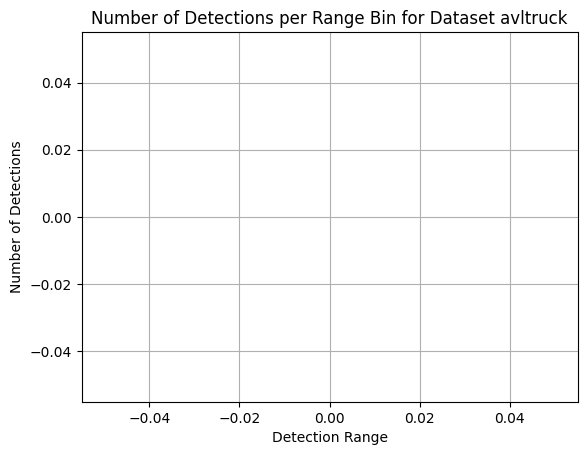

/home/cgriesbacher/.venvs/3dtrans/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


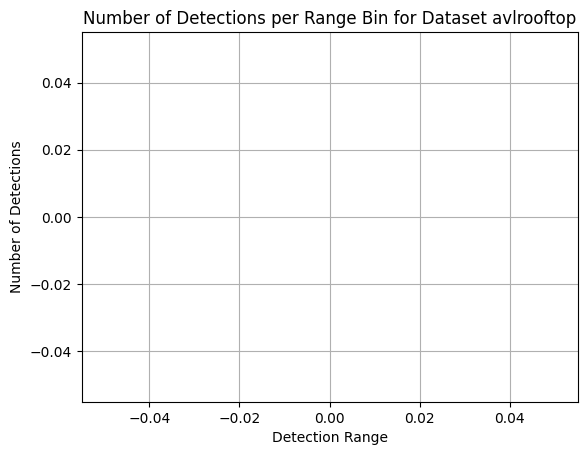

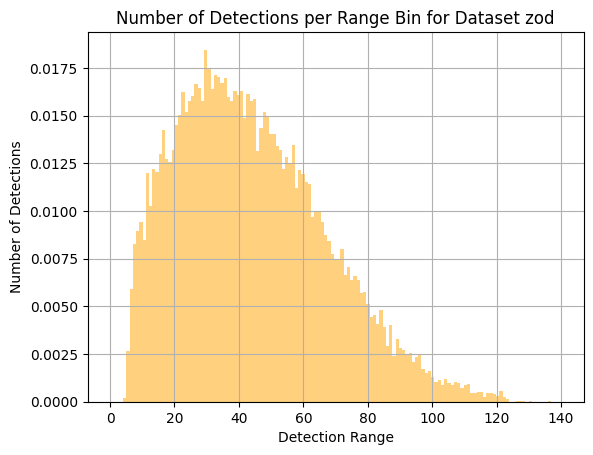

In [7]:
gt_labels = gt_labels_all
# add range to gt labels
gt_labels['x'] = gt_labels['gt_boxes_lidar'].apply(lambda x: x[0])
gt_labels['y'] = gt_labels['gt_boxes_lidar'].apply(lambda x: x[1])
gt_labels['range'] = np.sqrt(gt_labels['x']**2 + gt_labels['y']**2)
# add range to detections
df_det_vehicles['x'] = df_det_vehicles['boxes_lidar'].apply(lambda x: x[0])
df_det_vehicles['y'] = df_det_vehicles['boxes_lidar'].apply(lambda x: x[1])
df_det_vehicles['range'] = np.sqrt(df_det_vehicles['x']**2 + df_det_vehicles['y']**2)

datasets = gt_labels['dataset'].unique()
for dataset in datasets:
    gt_labels_dataset = gt_labels[gt_labels['dataset'] == dataset]
    df_det_vehicles_dataset = df_det_vehicles[df_det_vehicles['eval_dataset'] == dataset]

    max_range = 140
    gt_labels_dataset = gt_labels_dataset[gt_labels_dataset['range'] < max_range]
    df_det_vehicles_dataset = df_det_vehicles_dataset[df_det_vehicles_dataset['range'] < max_range]
    
    # Define bin edges (adjust the range and bin size as needed)
    bin_edges = np.linspace(0, 140, num=140)  # Create one bin for each meter of range

    # Bin the data
    binned_indices = pd.cut(gt_labels_dataset['range'], bins=bin_edges, include_lowest=True, labels=False)
    grouped = gt_labels_dataset.groupby(binned_indices)


    # Plot histogram
    #plt.hist(gt_labels_dataset['range'], bins=bin_edges, density=True, histtype='bar', label='Ground Truth', alpha=0.5)
    plt.hist(df_det_vehicles_dataset['range'], bins=bin_edges, density=True, histtype='bar', label='Detections', alpha=0.5, color='orange')
    # Labels and Titles
    plt.xlabel('Detection Range')
    plt.ylabel('Number of Detections')
    plt.title('Number of Detections per Range Bin for Dataset {}'.format(dataset))
    plt.grid(True)

    # Display the plot
    plt.show()



### Add detection true_labels to detections and detection results for gt labels

In [53]:
#downsample gt_loabels_all and detections_all to 2k frames
num_frames = 20000
#select 2k frames from detections
unique_frames = detections_all['frame_id'].unique()
np.random.shuffle(unique_frames)
selected_frames = unique_frames[:num_frames]

#reduce gt labels to frames that are in the detections
gt_labels_all = gt_labels_all[gt_labels_all['frame_id'].isin(detections_all['frame_id'].unique())]
#add x, y, range, angle
detections_all['x'] = detections_all['boxes_lidar'].apply(lambda x: x[0])
detections_all['y'] = detections_all['boxes_lidar'].apply(lambda x: x[1])
detections_all['range'] = np.sqrt(detections_all['x']**2 + detections_all['y']**2)
detections_all['angle'] = np.arctan2(detections_all['y'], detections_all['x'])*180/np.pi

gt_labels_all['x'] = gt_labels_all['gt_boxes_lidar'].apply(lambda x: x[0])
gt_labels_all['y'] = gt_labels_all['gt_boxes_lidar'].apply(lambda x: x[1])
gt_labels_all['range'] = np.sqrt(gt_labels_all['x']**2 + gt_labels_all['y']**2)
gt_labels_all['angle'] = np.arctan2(gt_labels_all['y'], gt_labels_all['x'])*180/np.pi

def plot_alignment_infos(df_det, df_gt):
    eval_datasets = df_det['eval_dataset'].unique()

    for eval_dataset in eval_datasets:
        #print max range and minmax angle for each dataset
        print(eval_dataset, "detections")
        print("max range: ", df_det[df_det['eval_dataset'] == eval_dataset]['range'].max())
        print("min angle: ", df_det[df_det['eval_dataset'] == eval_dataset]['angle'].min())
        print("max angle: ", df_det[df_det['eval_dataset'] == eval_dataset]['angle'].max())
        print("")

        print(eval_dataset, "gt labels")
        print("max range: ", df_gt[df_gt['dataset'] == eval_dataset]['range'].max())
        print("min angle: ", df_gt[df_gt['dataset'] == eval_dataset]['angle'].min())
        print("max angle: ", df_gt[df_gt['dataset'] == eval_dataset]['angle'].max())
        print("")

        #plot angle histo for detections and gt labels (same figure) for the vehicle class
        fig, axs = plt.subplots(1,2, figsize=(14, 7))

        #plot detections
        df_det_vehicles = df_det[(df_det['eval_dataset'] == eval_dataset)]
        df_det_vehicles = df_det_vehicles[df_det_vehicles['range'] < 140]
        sns.histplot(data=df_det_vehicles, x='angle', hue='eval_dataset', kde=False, element='step', binwidth=2, stat='density', common_norm=False, ax=axs[0])
        axs[0].set_xlabel("Angle")
        axs[0].set_ylabel("Count")
        axs[0].set_title(f"Class: Vehicle, Dataset: {eval_dataset}")

        #plot gt labels
        df_gt_vehicles = df_gt[(df_gt['dataset'] == eval_dataset)]
        df_gt_vehicles = df_gt_vehicles[df_gt_vehicles['range'] < 140]
        sns.histplot(data=df_gt_vehicles, x='angle', hue='dataset', kde=False, element='step', binwidth=2, stat='density', common_norm=False, ax=axs[1])
        axs[1].set_xlabel("Angle")
        axs[1].set_ylabel("Count")
        axs[1].set_title(f"Class: Vehicle, Dataset: {eval_dataset}")

        plt.tight_layout()

        plt.show()


#plot_alignment_infos(detections_vehicles, gt_labels_vehicles)

#align datasets
min_angle = -60
max_angle = 60
max_range = 140

detections_all = detections_all[(detections_all['angle'] >= min_angle) & (detections_all['angle'] <= max_angle)]
detections_all = detections_all[detections_all['range'] < max_range]
detections_all.reset_index(drop=True, inplace=True)

gt_labels_all = gt_labels_all[(gt_labels_all['angle'] >= min_angle) & (gt_labels_all['angle'] <= max_angle)]
gt_labels_all = gt_labels_all[gt_labels_all['range'] < max_range]
gt_labels_all.reset_index(drop=True, inplace=True)
#plot_alignment_infos(detections_vehicles, gt_labels_vehicles)


#reduce to vehicle class
detections_vehicles = detections_all[detections_all['name'] == 'Vehicle']
gt_labels_vehicles = gt_labels_all[gt_labels_all['names'] == 'Vehicle']
#reduce to selected frames
detections_vehicles = detections_vehicles[detections_vehicles['frame_id'].isin(selected_frames)]
detections_vehicles, gt_labels_vehicles = calc_ious(detections_vehicles, gt_labels_vehicles)


detectoins_predestrians = detections_all[detections_all['name'] == 'Pedestrian']
gt_labels_predestrians = gt_labels_all[gt_labels_all['names'] == 'Pedestrian']
#reduce to selected frames
detectoins_predestrians = detectoins_predestrians[detectoins_predestrians['frame_id'].isin(selected_frames)]
detections_pedestrians, gt_labels_pedestrians = calc_ious(detectoins_predestrians, gt_labels_predestrians)

detections_cyclists = detections_all[detections_all['name'] == 'Cyclist']
gt_labels_cyclists = gt_labels_all[gt_labels_all['names'] == 'Cyclist']
#reduce to selected frames
detections_cyclists = detections_cyclists[detections_cyclists['frame_id'].isin(selected_frames)]
detections_cyclists, gt_labels_cyclists = calc_ious(detections_cyclists, gt_labels_cyclists)

#detections_truck = detections_all[detections_all['name'] == 'Truck']
#gt_labels_truck = gt_labels_all[gt_labels_all['names'] == 'Truck']
##reduce to selected frames
#detections_truck = detections_truck[detections_truck['frame_id'].isin(selected_frames)]
#detections_truck, gt_labels_cyclists = calc_ious(detections_truck, gt_labels_truck)

detections = pd.DataFrame()
#detections = pd.concat([detections_vehicles, detections_pedestrians, detections_cyclists, detections_truck], axis=0)
detections = pd.concat([detections_vehicles, detections_pedestrians, detections_cyclists], axis=0)

#add col "with_gace" to detections
detections['with_gace'] = False
detections.loc[detections['eval_dataset'].str.contains("_gace"), 'with_gace'] = True


/tmp/ipykernel_980601/2837278466.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gt_labels['iou'] = 0
0it [00:00, ?it/s]
/tmp/ipykernel_980601/2837278466.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gt_labels[f'detected_{iou_threshold}'] = gt_labels['iou'] >= iou_threshold
/tmp/ipykernel_980601/2837278466.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

No label percentage: 33.61%: 100%|██████████| 490/490 [00:01<00:00, 488.49it/s]
/tmp/ipykernel_980601/2837278466.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gt_labels[f'detected_{iou_threshold}'] = gt_labels['iou'] >= iou_threshold
/tmp/ipykernel_980601/2837278466.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gt_labels[f'detected_{iou_threshold}'] = gt_labels['iou'] >= iou_threshold
/tmp/ipykernel_980601/2837278466.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

with gace


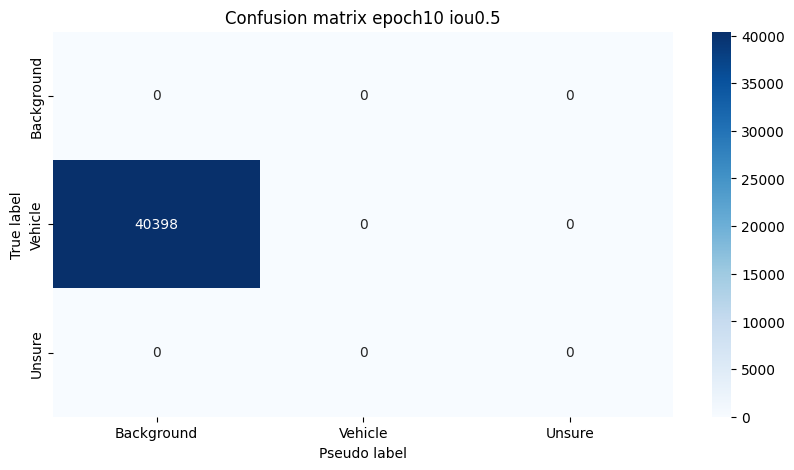

without gace


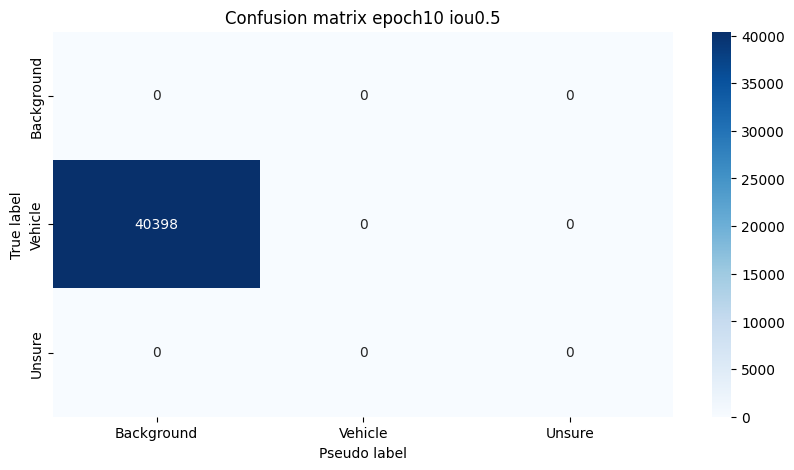

In [85]:
eval_dataset = "zod"
epoch = "10"
iou = 0.5

print("with gace")
detections_vehicles_gace = detections_vehicles[detections_vehicles['eval_dataset'] == eval_dataset+'_gace']
plot_confusion_matrix(detections_vehicles_gace, gt_labels_vehicles, iou, epochs=epoch, pseudo_labels_folder_path=None, show_plot=True, do_print=False)

print("without gace")
detections_vehicles = detections_vehicles[detections_vehicles['eval_dataset'] == eval_dataset]
plot_confusion_matrix(detections_vehicles, gt_labels_vehicles, iou, epochs=epoch, pseudo_labels_folder_path=None, show_plot=True, do_print=False)

Pedestrian
detected objects
2623
2623

detected frames
490
490


(0.0, 100.8)

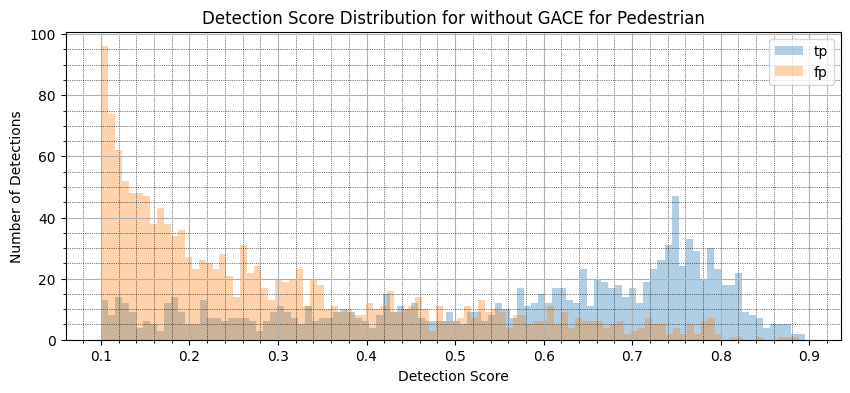

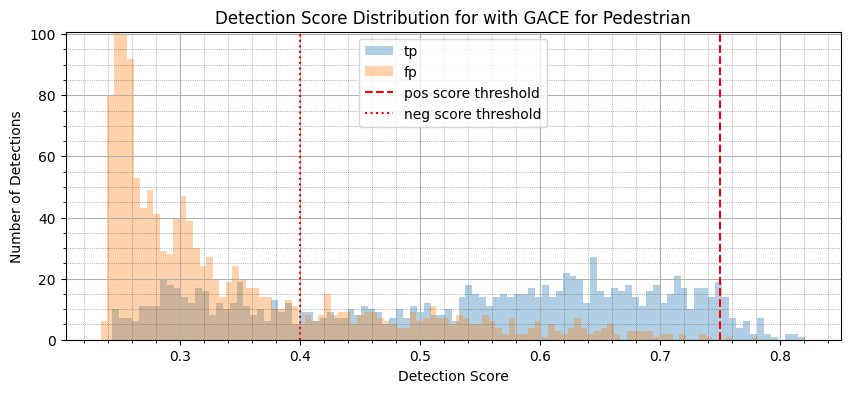

In [48]:
clss = "Pedestrian"

#for clss in detections['name'].unique():
print(clss)
detections_class = detections[detections['name'] == clss]
detections_gace = detections_class[detections_class['with_gace'] == True]
detections_no_gace = detections_class[detections_class['with_gace'] == False]

print("detected objects")
print(len(detections_gace))
print(len((detections_no_gace)))
print("")
print("detected frames")
print(len(detections_gace["frame_id"].unique()))
print(len(detections_no_gace["frame_id"].unique()))

pos_scorethreshmap = {
    "Vehicle": 0.85,
    "Pedestrian": 0.75,
    "Cyclist": 0.85,
    "Truck": 0.90,
}
neg_scorethreshmap = {
    "Vehicle": 0.3,
    "Pedestrian": 0.4,
    "Cyclist": 0.5,
    "Truck": 0.60,
}

pos_score_thresh = pos_scorethreshmap[clss]
neg_score_thresh = neg_scorethreshmap[clss]


detections_no_gace_tp = detections_no_gace[(detections_no_gace[f'detected_0.1'] == True)]
detections_no_gace_fp = detections_no_gace[(detections_no_gace[f'detected_0.1'] == False)]

plt.figure(figsize=(10, 4))
detections_no_gace_tp["score"].hist(bins=100, alpha=0.35, label="tp")    
detections_no_gace_fp["score"].hist(bins=100, alpha=0.35, label="fp")
plt.legend()
plt.xlabel("Detection Score")
plt.ylabel("Number of Detections")
plt.title("Detection Score Distribution for without GACE for " + clss)
plt.minorticks_on()
#plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax = plt.gca()
#plt.gca().set_ylim([0, 500])
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()

detections_gace_tp = detections_gace[(detections_gace[f'detected_0.1'] == True)]
detections_gace_fp = detections_gace[(detections_gace[f'detected_0.1'] == False)]


plt.figure(figsize=(10, 4))
detections_gace_tp["score"].hist(bins=100, alpha=0.35, label="tp")    
detections_gace_fp["score"].hist(bins=100, alpha=0.35, label="fp")
plt.axvline(x=pos_score_thresh, color='red', linestyle='--', label="pos score threshold")
plt.axvline(x=neg_score_thresh, color='red', linestyle=':', label="neg score threshold")
plt.legend()
plt.xlabel("Detection Score")
plt.ylabel("Number of Detections")
plt.title("Detection Score Distribution for with GACE for "+ clss)
plt.minorticks_on()
#plt.grid(which='major', linestyle='-', linewidth='0.5', color='black', alpha=0.5)
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black', alpha=0.5)
ax = plt.gca()
#plt.gca().set_ylim([0, 500])
xlim = plt.gca().get_xlim()
#ylim = plt.gca().get_ylim()
plt.gca().set_xlim(xlim)
plt.gca().set_ylim(ylim)

#ax.set_xlim(xlim)
ax.set_ylim(ylim)

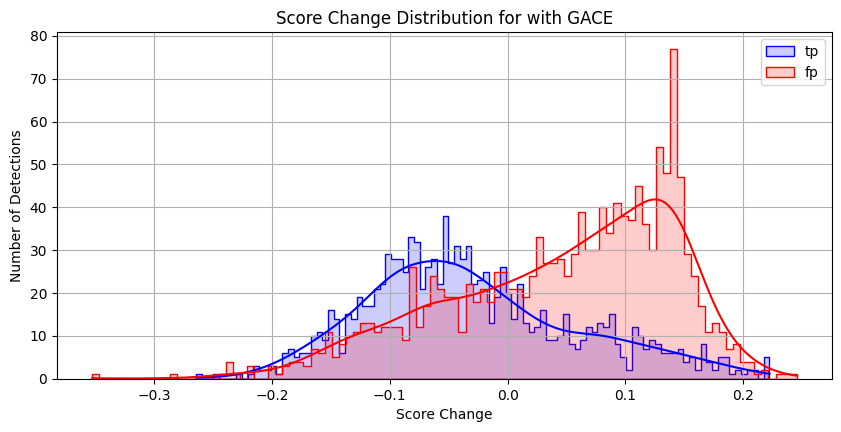

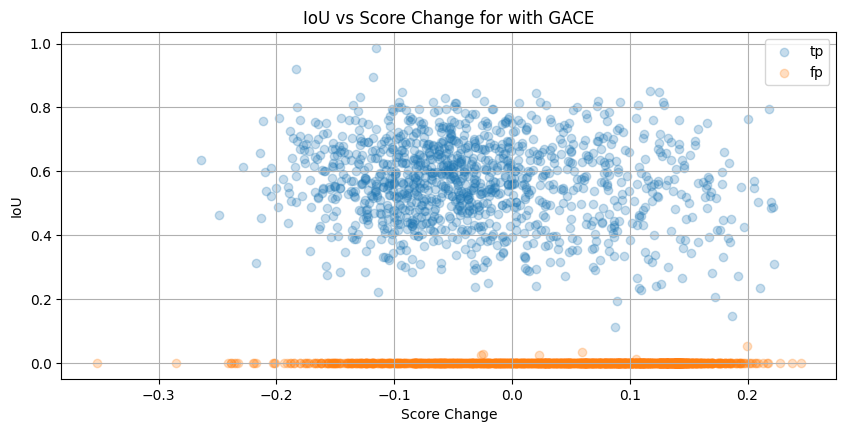

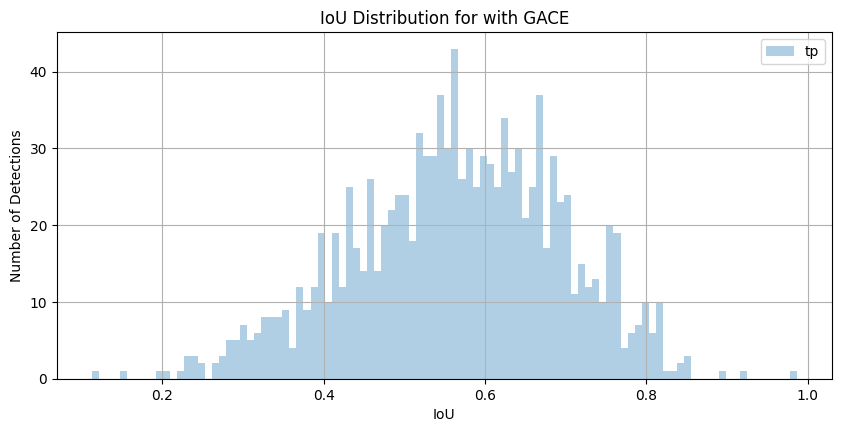

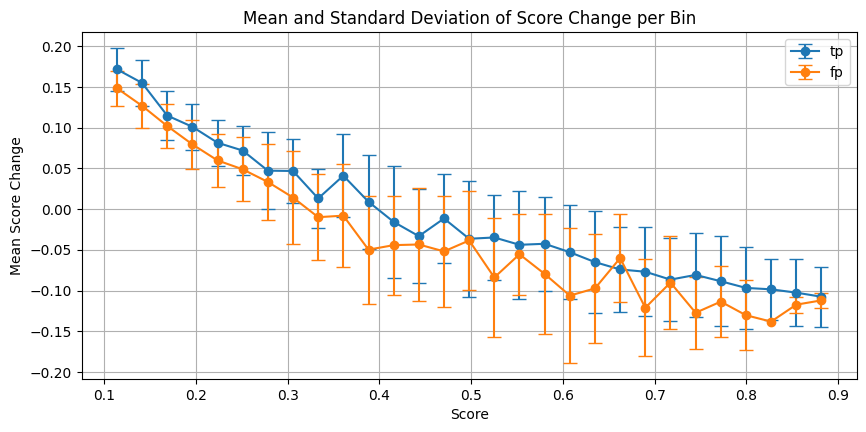

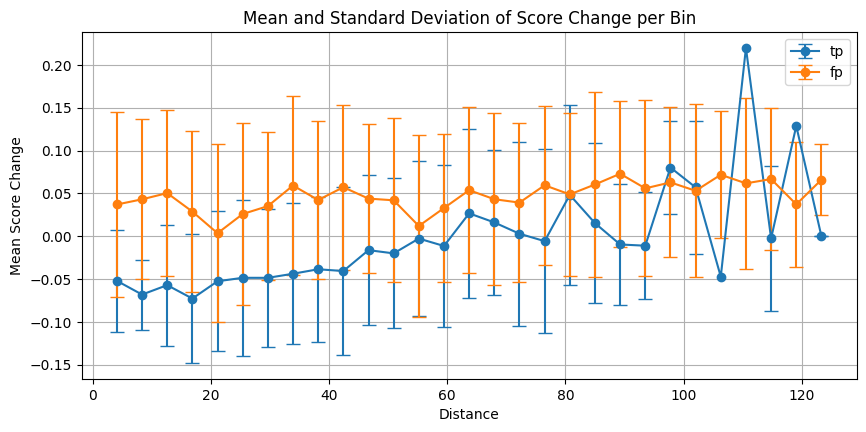

In [49]:

#plot histo of score change and git a gaussian (with sns)
plt.figure(figsize=(10, 4.5))
sns.histplot(data=detections_gace_tp, x='score_change', kde=True, element='step', stat='count', common_norm=False, label="tp", alpha=0.2, color='blue', bins=100)
sns.histplot(data=detections_gace_fp, x='score_change', kde=True, element='step', stat='count', common_norm=False, label="fp", alpha=0.2, color='red', bins=100)
plt.legend()
plt.xlabel("Score Change")
plt.ylabel("Number of Detections")
plt.title("Score Change Distribution for with GACE")
plt.grid(True)
plt.show()

# correlation between iou and score_change
plt.figure(figsize=(10, 4.5))
plt.scatter(detections_gace_tp['score_change'], detections_gace_tp['iou'], label="tp", alpha=0.25)
plt.scatter(detections_gace_fp['score_change'], detections_gace_fp['iou'], label="fp", alpha=0.25)
plt.legend()
plt.xlabel("Score Change")
plt.ylabel("IoU")
plt.title("IoU vs Score Change for with GACE")
plt.grid(True)
plt.show()



#histo of ious
plt.figure(figsize=(10, 4.5))
detections_gace_tp['iou'].hist(bins=100, alpha=0.35, label="tp")
plt.legend()
plt.xlabel("IoU")
plt.ylabel("Number of Detections")
plt.title("IoU Distribution for with GACE")
plt.show()


###plotting score change over score###
# Define bin edges (adjust the range and bin size as needed)
min_score = detections_gace['prev_score'].min()
max_score = detections_gace['prev_score'].max()
bin_edges = np.linspace(min_score, max_score, num=30)  

# Bin the data
binned_indices_tp = pd.cut(detections_gace_tp['prev_score'], bins=bin_edges, include_lowest=True, labels=False)
grouped_tp = detections_gace_tp.groupby(binned_indices_tp)
binned_indices_fp = pd.cut(detections_gace_fp['prev_score'], bins=bin_edges, include_lowest=True, labels=False)
grouped_fp = detections_gace_fp.groupby(binned_indices_fp)

#check for bins without values
bins = binned_indices_fp.unique()
bins.sort()


# Calculate mean and standard deviation for each bin
mean_scores_tp = grouped_tp['score_change'].mean()
std_devs_tp = grouped_tp['score_change'].std()
mean_scores_fp = grouped_fp['score_change'].mean()
std_devs_fp = grouped_fp['score_change'].std()

# Collect scores for each bin for boxplots
binned_scores_tp = [group['score_change'].values for _, group in grouped_tp]
binned_scores_fp = [group['score_change'].values for _, group in grouped_fp]

# Midpoints of bins for plotting
bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plotting
plt.figure(figsize=(10, 4.5))
if len(mean_scores_tp) != len(bin_midpoints):
    len_diff = len(bin_midpoints) - len(mean_scores_tp)
    mean_scores_tp = np.append(mean_scores_tp, np.zeros(len_diff))
    std_devs_tp = np.append(std_devs_tp, np.zeros(len_diff))
plt.errorbar(bin_midpoints, mean_scores_tp, yerr=std_devs_tp, fmt='-o', capsize=5, label="tp")

if len(mean_scores_fp) != len(bin_midpoints):
    len_diff = len(bin_midpoints) - len(mean_scores_fp)
    mean_scores_fp = np.append(mean_scores_fp, np.zeros(len_diff))
    std_devs_fp = np.append(std_devs_fp, np.zeros(len_diff))

plt.errorbar(bin_midpoints, mean_scores_fp, yerr=std_devs_fp, fmt='-o', capsize=5, label="fp")

# Labels and Titles
plt.xlabel('Score')
plt.ylabel('Mean Score Change')
plt.title('Mean and Standard Deviation of Score Change per Bin')
plt.grid(True)
plt.legend()
# Display the plot
plt.show()


###plotting score change over distance###
# Define bin edges (adjust the range and bin size as needed)
min_range = detections_gace['range'].min()
max_range = detections_gace['range'].max()
bin_edges = np.linspace(min_range, max_range, num=30)

# Bin the data
binned_indices_tp = pd.cut(detections_gace_tp['range'], bins=bin_edges, include_lowest=True, labels=False)
grouped_tp = detections_gace_tp.groupby(binned_indices_tp)
binned_indices_fp = pd.cut(detections_gace_fp['range'], bins=bin_edges, include_lowest=True, labels=False)
grouped_fp = detections_gace_fp.groupby(binned_indices_fp)

#check for bins without values
bins = binned_indices_fp.unique()
bins.sort()


# Calculate mean and standard deviation for each bin
mean_scores_tp = grouped_tp['score_change'].mean()
std_devs_tp = grouped_tp['score_change'].std()
mean_scores_fp = grouped_fp['score_change'].mean()
std_devs_fp = grouped_fp['score_change'].std()

# Collect scores for each bin for boxplots
binned_scores_tp = [group['score_change'].values for _, group in grouped_tp]
binned_scores_fp = [group['score_change'].values for _, group in grouped_fp]

# Midpoints of bins for plotting
bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plotting
plt.figure(figsize=(10, 4.5))
if len(mean_scores_tp) != len(bin_midpoints):
    len_diff = len(bin_midpoints) - len(mean_scores_tp)
    mean_scores_tp = np.append(mean_scores_tp, np.zeros(len_diff))
    std_devs_tp = np.append(std_devs_tp, np.zeros(len_diff))
plt.errorbar(bin_midpoints, mean_scores_tp, yerr=std_devs_tp, fmt='-o', capsize=5, label="tp")

if len(mean_scores_fp) != len(bin_midpoints):
    len_diff = len(bin_midpoints) - len(mean_scores_fp)
    mean_scores_fp = np.append(mean_scores_fp, np.zeros(len_diff))
    std_devs_fp = np.append(std_devs_fp, np.zeros(len_diff))

plt.errorbar(bin_midpoints, mean_scores_fp, yerr=std_devs_fp, fmt='-o', capsize=5, label="fp")

# Labels and Titles
plt.xlabel('Distance')
plt.ylabel('Mean Score Change')
plt.title('Mean and Standard Deviation of Score Change per Bin')
plt.grid(True)
plt.legend()
# Display the plot
plt.show()




### Calculate precision for every score and plot results

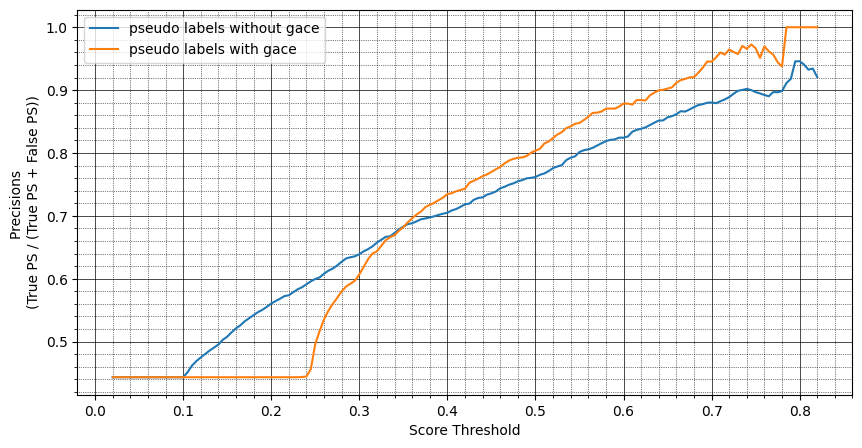

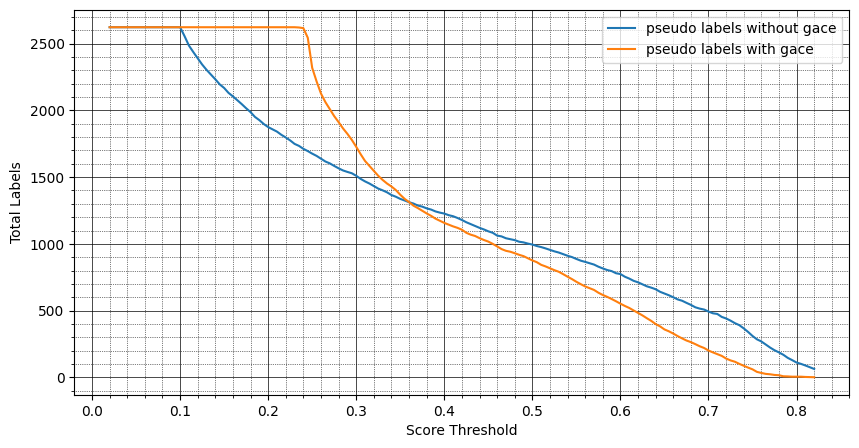

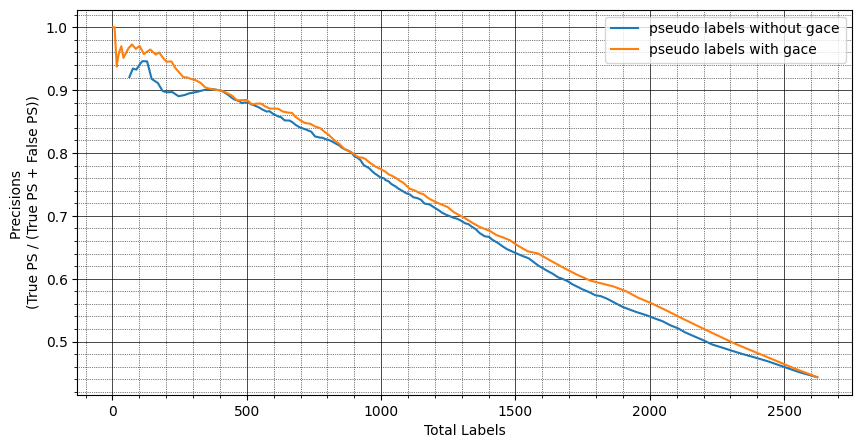

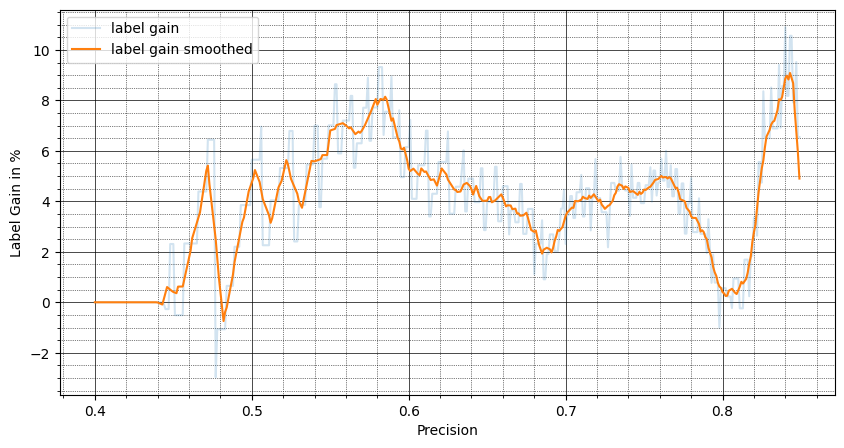

Label gain@0.8: 5 (0.56%))
Score threshold:  0.5500000000000002
Score threshold:  0.4950000000000001
Label gain@0.9: 59 (17.35%))
Score threshold:  0.7450000000000001
Score threshold:  0.6400000000000001


In [51]:

def calc_tp_precisions(detections, score_thresholds, iou_threshold):
    precisions = []
    total_labels = []
    for score_threshold in score_thresholds:
        
        detections_tp = detections[(detections[f'detected_{iou_threshold}'] == True) & (detections['score'] >= score_threshold)]
        detections_fn = detections[(detections[f'detected_{iou_threshold}'] == False) & (detections['score'] >= score_threshold)]
        if len(detections_tp) + len(detections_fn) == 0:
            precisions.append(None)
            total_labels.append(None)
            continue
        precision = len(detections_tp)/(len(detections_tp) + len(detections_fn))
        precisions.append(precision)
        total_labels.append(len(detections_tp) + len(detections_fn))
    return precisions, total_labels


def calc_fp_precisions(detections, score_thresholds, iou_threshold):
    precisions = []
    total_labels = []
    for score_threshold in score_thresholds:
        
        detections_tp = detections[(detections[f'detected_{iou_threshold}'] == True) & (detections['score'] < score_threshold)]
        detections_fn = detections[(detections[f'detected_{iou_threshold}'] == False) & (detections['score'] < score_threshold)]
        if len(detections_tp) + len(detections_fn) == 0:
            precisions.append(None)
            total_labels.append(None)
            continue
        precision = len(detections_fn)/(len(detections_tp) + len(detections_fn))
        precisions.append(precision)
        total_labels.append(len(detections_tp) + len(detections_fn))
    return precisions, total_labels


def plot_precisions(detections, label, iou_threshold, detections2=None, label2=None):
    score_thresholds = np.arange(0.02, 0.9, 0.005)
    #cap score thresholds at max score
    score_thresholds = score_thresholds[score_thresholds <= detections['score'].max()]
    if detections2 is not None:
        score_thresholds = score_thresholds[score_thresholds <= detections2['score'].max()]
    precisions, total_labels = calc_tp_precisions(detections, score_thresholds, iou_threshold)
    if detections2 is not None:
        precisions2, total_labels2 = calc_tp_precisions(detections2, score_thresholds, iou_threshold)

    plt.figure(figsize=(10, 5))
    plt.plot(score_thresholds, precisions, label=label)
    if detections2 is not None:
        plt.plot(score_thresholds, precisions2, label=label2)
    plt.xlabel("Score Threshold")
    plt.ylabel("Precisions \n(True PS / (True PS + False PS))")
    plt.legend()
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.show()

    #plot score threshold vs total labels
    plt.figure(figsize=(10, 5))
    plt.plot(score_thresholds, total_labels, label=label)
    if detections2 is not None:
        plt.plot(score_thresholds, total_labels2, label=label2)
    plt.xlabel("Score Threshold")
    plt.ylabel("Total Labels")
    plt.legend()
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(total_labels, precisions, label=label)
    if detections2 is not None:
        plt.plot(total_labels2, precisions2, label=label2)
    plt.xlabel("Total Labels")
    plt.ylabel("Precisions \n(True PS / (True PS + False PS))")
    plt.legend()
    plt.minorticks_on()
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.show()

    
    if detections2 is not None:
        precision_thresholds = np.arange(0.4, 0.85, 0.001)
        precision_idxs = [np.argmin(np.abs(np.array(precisions) - precision)) for precision in precision_thresholds]
        precision_idxs2 = [np.argmin(np.abs(np.array(precisions2) - precision)) for precision in precision_thresholds]
        total_labels_diff = [total_labels2[precision_idxs2[i]] - total_labels[precision_idxs[i]] for i in range(len(precision_idxs))]
        total_labels_diff_percent = [round(total_labels_diff[i]/total_labels[precision_idxs[i]]*100,2) for i in range(len(precision_idxs))]
        plt.figure(figsize=(10, 5))
        #smooth total_labels_diff_percent
        total_labels_diff_percent_smooth = np.convolve(total_labels_diff_percent, np.ones(10)/10, mode='same')
        plt.plot(precision_thresholds, total_labels_diff_percent, label="label gain", alpha=0.2)
        plt.plot(precision_thresholds, total_labels_diff_percent_smooth, label="label gain smoothed")
        plt.xlabel("Precision")
        plt.ylabel("Label Gain in %")
        plt.legend()
        plt.minorticks_on()
        plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
        plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
        plt.show()

    if detections2 is not None:
        target_precisions = [0.8, 0.9]
        for target_precision in target_precisions:
            precision_idx = np.argmin(np.abs(np.array(precisions) - target_precision))
            precision_idx2 = np.argmin(np.abs(np.array(precisions2) - target_precision))
            label_gain = total_labels2[precision_idx2] - total_labels[precision_idx]
            print(f"Label gain@{target_precision}: {label_gain} ({round(label_gain/total_labels[precision_idx]*100,2)}%))")
            print("Score threshold: ", score_thresholds[precision_idx])
            print("Score threshold: ", score_thresholds[precision_idx2])

    
    

plot_precisions(detections_no_gace, "pseudo labels without gace", 0.1, detections_gace, "pseudo labels with gace")


### Analyze label population for each epoch on the validation set

Evaluation of ckpts is needed for this step

In [24]:
eval_folder = "/home/cgriesbacher/thesis/3DTrans/output_okeanos/avltruck_models/pvrcnnpp_STzod_ped/D16_21epochs_STzod_ft_D6_50epochs_fov_gace_labelupdate_longerepochs/eval"

#load all subfolders
subfolders = [f.path for f in os.scandir(eval_folder) if f.is_dir() ]
subfolders.sort()

#exclude folder eval_with_train
subfolders = [folder for folder in subfolders if "eval_with_train" not in folder]

results_df = pd.DataFrame()
for subfolder in subfolders:
    #get epoch from folder name
    epoch = int(subfolder.split("_")[-1])
    #go into first dir
    subfolder = os.path.join(subfolder, os.listdir(subfolder)[0])
    subfolder = os.path.join(subfolder, os.listdir(subfolder)[0])

    #load results.pkl
    results_path = os.path.join(subfolder, "result.pkl")

    if not os.path.exists(results_path):
        print("result.pkl not found for epoch ", epoch)
        continue
    else:
        with open(results_path, 'rb') as f:
            results = pkl.load(f)

    df = pd.DataFrame()
    df = load_detections(results_path, df, train_dataset="avltruck", eval_dataset="zod")
    df['epoch'] = epoch
    results_df = pd.concat([results_df, df], axis=0)

df.value_counts("name")

print(len(df["frame_id"].unique()))

loaded 2036 detections on dataset zod with model trained on avltruck
loaded 1905 detections on dataset zod with model trained on avltruck
loaded 2023 detections on dataset zod with model trained on avltruck
loaded 1913 detections on dataset zod with model trained on avltruck
loaded 1591 detections on dataset zod with model trained on avltruck
loaded 1733 detections on dataset zod with model trained on avltruck
loaded 1234 detections on dataset zod with model trained on avltruck
loaded 1277 detections on dataset zod with model trained on avltruck
loaded 1414 detections on dataset zod with model trained on avltruck
loaded 1472 detections on dataset zod with model trained on avltruck
loaded 1382 detections on dataset zod with model trained on avltruck
loaded 1601 detections on dataset zod with model trained on avltruck
loaded 1285 detections on dataset zod with model trained on avltruck
loaded 1266 detections on dataset zod with model trained on avltruck
loaded 1595 detections on dataset 

In [25]:
#load gt labels
gt_labels_all = pd.DataFrame()
gt_labels_all = load_gt_labels("val")
gt_labels = gt_labels_all[gt_labels_all["dataset"] == "zod"]

#filter gt frames for frames in det
gt_labels = gt_labels[gt_labels['frame_id'].isin(results_df['frame_id'].unique())]

#calc num_detections for each class
num_detections_gt = gt_labels.groupby(['names']).size().reset_index(name='counts')

print(num_detections_gt.value_counts())

print(len(gt_labels["frame_id"].unique()))




Dropped 341 rows with NaNs
names       counts
Cyclist     343       1
Pedestrian  1872      1
Truck       477       1
Vehicle     5991      1
dtype: int64
505


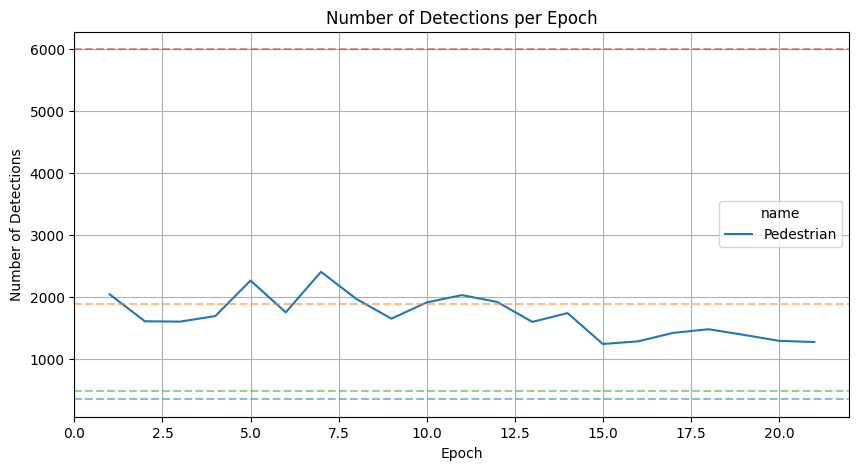

In [26]:
#plot number of detections for each class per epoch in sns, class is the hue
#calc num detections for each class
num_detections = results_df.groupby(['epoch', 'name']).size().reset_index(name='counts')
#plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=num_detections, x="epoch", y="counts", hue="name")
plt.xlabel("Epoch")
plt.ylabel("Number of Detections")
#plt.ylim([0, 2000])
plt.title("Number of Detections per Epoch")
plt.grid(True)
#print gt num detections as baseline
for i, row in num_detections_gt.iterrows():
    plt.axhline(y=row['counts'], color=sns.color_palette()[i], linestyle='--', label=row['names'], alpha=0.5)
#set ylim
#plt.gca().set_ylim([0, 1000])
plt.show()


### Analyze ps files

In [28]:
#load pseudo labels
ps_folder = "/home/cgriesbacher/thesis/3DTrans/output_okeanos/avltruck_models/pvrcnnpp_STzod_ped/D16_21epochs_STzod_ft_D6_50epochs_fov_gace_labelupdate_longerepochs/ps_label"
 
#load all files that start with ps
pseudo_labels = pd.DataFrame()
for file in os.listdir(ps_folder):
    if file.startswith("ps"):
        epoch = int(file.split("_")[-1].split(".")[0][1:])
        pseudo_labels = load_pseudo_labels(os.path.join(ps_folder, file), pseudo_labels, train_dataset="avltruck", eval_dataset="zod", epoch=epoch)
pseudo_labels

loaded 15341 pseudo labels on dataset zod with model trained on avltruck
loaded 12210 pseudo labels on dataset zod with model trained on avltruck
loaded 14868 pseudo labels on dataset zod with model trained on avltruck


,score,name,boxes_lidar,frame_id,eval_dataset,train_dataset,epoch
0,0.990808,Vehicle,"[12.835792541503906, 15.20685863494873, 0.2613...",1,zod,avltruck,7
1,0.748616,Unsure,"[72.61827087402344, 13.930338859558105, 0.3954...",1,zod,avltruck,7
2,0.794915,Vehicle,"[31.872743606567383, -12.399606704711914, 1.18...",1,zod,avltruck,7
3,0.501031,Unsure,"[33.17963790893555, -21.8314208984375, 1.74767...",1,zod,avltruck,7
4,0.629907,Unsure,"[12.446928977966309, 16.630859375, 0.480165392...",1,zod,avltruck,7
...,...,...,...,...,...,...,...
42414,0.795203,Vehicle,"[20.899574279785156, 20.3301944732666, 1.08879...",5619,zod,avltruck,0
42415,0.868966,Vehicle,"[49.957027435302734, 1.4612882137298584, 1.896...",5619,zod,avltruck,0
42416,0.972596,Vehicle,"[30.24837875366211, 24.506052017211914, 1.2052...",5619,zod,avltruck,0
42417,0.698091,Unsure,"[26.531404495239258, -12.232074737548828, 1.00...",5619,zod,avltruck,0


In [29]:
pseudo_labels["name"].value_counts()

Unsure     35116
Vehicle     7303
Name: name, dtype: int64

### Analyze IOU threshold

/tmp/ipykernel_3632238/3053227415.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  detections_vehicles[f'detected_{iou_threshold}'] = detections_vehicles['iou'] >= iou_threshold
/tmp/ipykernel_3632238/3053227415.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gt_labels_vehicles[f'detected_{iou_threshold}'] = gt_labels_vehicles['iou'] >= iou_threshold
/tmp/ipykernel_3632238/3053227415.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

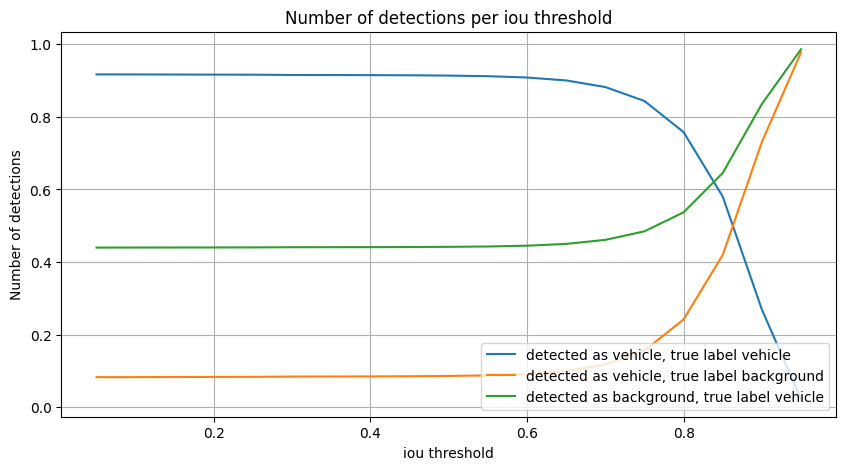

In [31]:

iou_thresholds = np.arange(0.05, 1, 0.05)

vehicles_vehicle = []
vehicles_background = []
background_vehicle = []

for iou_threshold in iou_thresholds:
    detections_vehicles[f'detected_{iou_threshold}'] = detections_vehicles['iou'] >= iou_threshold
    gt_labels_vehicles[f'detected_{iou_threshold}'] = gt_labels_vehicles['iou'] >= iou_threshold

    
    vehicles_vehicle.append(len(detections_vehicles[(detections_vehicles[f'detected_{iou_threshold}'] == True) & (detections_vehicles['true_label'] == 'Vehicle')]))
    vehicles_background.append(len(detections_vehicles[(detections_vehicles[f'detected_{iou_threshold}'] == False)]))
    background_vehicle.append(len(gt_labels_vehicles[(gt_labels_vehicles[f'detected_{iou_threshold}'] == False) & (gt_labels_vehicles['names'] == 'Vehicle')]))

#convert to percentage of detections
vehicles_vehicle = np.array(vehicles_vehicle)/len(detections_vehicles)
vehicles_background = np.array(vehicles_background)/len(detections_vehicles)
background_vehicle = np.array(background_vehicle)/len(gt_labels_vehicles)

plt.figure(figsize=(10, 5))
plt.title('Number of detections per iou threshold')
plt.plot(iou_thresholds, vehicles_vehicle, label='detected as vehicle, true label vehicle')
plt.plot(iou_thresholds, vehicles_background, label='detected as vehicle, true label background')
plt.plot(iou_thresholds, background_vehicle, label='detected as background, true label vehicle')
plt.legend()
plt.xlabel('iou threshold')
plt.ylabel('Number of detections')
plt.grid(True)
plt.show()


In [ ]:
detections_vehicles['score_diff'] = detections_vehicles['range'].apply(lambda x: diff[np.clip(np.digitize(x, bin_edges)-1, 0, len(diff)-1)])


In [ ]:
detections_vehicles['adjusted_score'] = detections_vehicles['score'] + detections_vehicles['score_diff']

In [ ]:
detections_vehicles_gace

### Analyze score threshold

In [ ]:
pd.options.mode.chained_assignment = None  # default='warn'
def plot_scorethreshold_analysis(detections_vehicles, iou_threshold): 
    #detections_vehicles = detections_vehicles_gace
    score_thresholds = np.arange(0.05, 1, 0.05)
    #iou_thresholds = [0.3, 0.5, 0.7]
    iou_thresholds = [0.1]
    line_types = ['-', '--', ':']
    colors = ['blue', 'orange', 'green', 'red']

    plt.figure(figsize=(10, 5))
    plt.title('Number of detections per score for IOU threshold')

    max_dist = 130

    delta_scores = np.arange(-1, 1, 0.1)
    delta_scores = [-0.0]

    for delta_score in delta_scores:
        k = delta_score/max_dist
        print("delta_score is", delta_score, "k is", k)
        for iou_threshold in iou_thresholds:
            true_tp = []
            false_tp = []
            true_fn = []
            false_fn = []

            for score_threshold in score_thresholds:
                
                #range dependent score threshold
                #range_dep_score_threshold = score_threshold + k*detections_vehicles['range']
                #detections_vehicles.loc[:,f'ps_vehicle_{score_threshold}'] = detections_vehicles['score'] >= range_dep_score_threshold

                #static score threshold
                detections_vehicles[f'ps_vehicle_{score_threshold}'] = detections_vehicles['score'] >= score_threshold
                
                #reduce to max dist
                detections_vehicles_max_dist = detections_vehicles[detections_vehicles['range'] < max_dist]


                true_tp.append(len(detections_vehicles[(detections_vehicles[f'ps_vehicle_{score_threshold}'] == True) & (detections_vehicles[f'detected_{iou_threshold}'] == True)]))
                false_tp.append(len(detections_vehicles[(detections_vehicles[f'ps_vehicle_{score_threshold}'] == True) & (detections_vehicles[f'detected_{iou_threshold}'] == False)]))
                true_fn.append(len(detections_vehicles[(detections_vehicles[f'ps_vehicle_{score_threshold}'] == False) & (detections_vehicles[f'detected_{iou_threshold}'] == False)]))
                false_fn.append(len(detections_vehicles[(detections_vehicles[f'ps_vehicle_{score_threshold}'] == False) & (detections_vehicles[f'detected_{iou_threshold}'] == True)]))


            true_tp = np.array(true_tp)
            false_tp = np.array(false_tp)
            true_fn = np.array(true_fn)
            false_fn = np.array(false_fn)
            
            # convert to percentage of detections
            true_tp = np.array(true_tp)/len(detections_vehicles)
            false_tp = np.array(false_tp)/len(detections_vehicles)
            true_fn = np.array(true_fn)/len(detections_vehicles)
            false_fn = np.array(false_fn)/len(detections_vehicles)

            # XXX: Chance percentage to percentage of actual true labels 

            true_labels = true_tp + true_fn
            false_labels = false_tp + false_fn

            plt.plot(score_thresholds, true_labels, label=f'true_ps, iou {iou_threshold}', linestyle="-", color=colors[0])
            plt.plot(score_thresholds, false_labels, label=f'false_ps, iou {iou_threshold}', linestyle="-", color=colors[1])
            plt.plot(score_thresholds, true_tp, label='ps vehicle, actually vehicle', linestyle="--", color=colors[0], alpha=0.5)
            plt.plot(score_thresholds, false_tp, label='ps vehicle, actually background', linestyle="--", color=colors[1], alpha=0.5)
            plt.plot(score_thresholds, true_fn, label='ps background, actually background', linestyle="--", color=colors[2], alpha=0.5)
            plt.plot(score_thresholds, false_fn, label='ps background, actually vehicle', linestyle="--", color=colors[3], alpha=0.5)

            best_score_index = np.argmax(true_labels)
            best_score_threshold = score_thresholds[best_score_index]
            print("most true labels for iou", iou_threshold, "is", np.round(best_score_threshold, 2), "with", np.round(true_labels[best_score_index], 3) ," true labels and", np.round(false_labels[best_score_index], 3), "false labels")
            print("false vehicles", np.round(false_tp[best_score_index], 3))
            print("undetected vehicles", np.round(false_fn[best_score_index], 3))

    #plot legend outside of plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel('score threshold')
    plt.ylabel('Percentage of detections')
    plt.minorticks_on()
    plt.grid(True)
    plt.show()


In [ ]:
plot_scorethreshold_analysis(detections_no_gace, 0.1)
plot_scorethreshold_analysis(detections_gace, 0.1)